# Problem Statement
<p>The process of assessing and validating insurance claims for damaged car outer body parts is often time-consuming, manual, and subjective. Insurance companies face challenges in accurately detecting and evaluating the extent of damage, leading to potential discrepancies, delays, and customer dissatisfaction. Therefore, there is a need to develop an automated computer vision system that can accurately detect and classify damaged car outer body parts, enabling insurance companies to streamline their claims processing workflow and enhance customer satisfaction.</p>
<p>The main problems to be addressed in this project include:</p>
<ol>
    <li>Inaccurate detection: The current manual inspection process for damaged car outer body parts can be subjective and prone to human error, resulting in inaccurate assessments. An automated system is required to improve the accuracy of damage detection, ensuring a fair evaluation of insurance claims.</li>
    <li>Inefficient claims processing: Manual assessment of damaged car outer body parts is time-consuming, leading to delays in claim settlements and increased operational costs for insurance companies. An automated solution would enable faster and more efficient claims processing, reducing the time and resources required for evaluation.</li>
    <li>Lack of standardization: The absence of standardized procedures and guidelines for assessing damaged car outer body parts can lead to inconsistencies in claim evaluations. Developing a computer vision system that follows standardized protocols would ensure consistent and fair assessments across different insurance claims.</li>
    <li>Variability in car models and damage types: Car models and designs vary significantly, and damage can manifest in different ways, making it challenging to develop a universal system that can accurately detect various types of damage across different vehicle types. The system needs to address this variability and accommodate a wide range of car models and damage scenarios.</li>    
</ol>

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pandas as pd
from pycocotools.coco import COCO
import seaborn as sns
from ultralytics import YOLO
from IPython.display import display, Image

In [2]:
train_images = glob("./dataset/train/images/*.jpg")[:9]

# Dataset Used: COCO Car Damage
The dataset contains car images with one or more damaged parts. The img/ folder has all 80 images in the dataset. There are three more folders train/, val/ and test/ for training, validation and testing purposes respectively.

Link: https://www.kaggle.com/datasets/lplenka/coco-car-damage-detection-dataset

In [7]:
coco = COCO("./dataset/train/COCO_mul_train_annos.json")

cat_ids = []
for obj in coco.getAnnIds():
    cat_ids.append(coco.cats[coco.loadAnns(obj)[0]["category_id"]]["name"])

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


## Dataset Analysis (Categorical)
- dataset provided the body parts of the 
- headlamps category is dominating the dataset
- major damage is usually belongs to door, hood, and bumper
    - hood and door might comes in severe damage area
    - bumper can be considers as the medium level damage
    - headlights majorly comes under maintance or low level damage


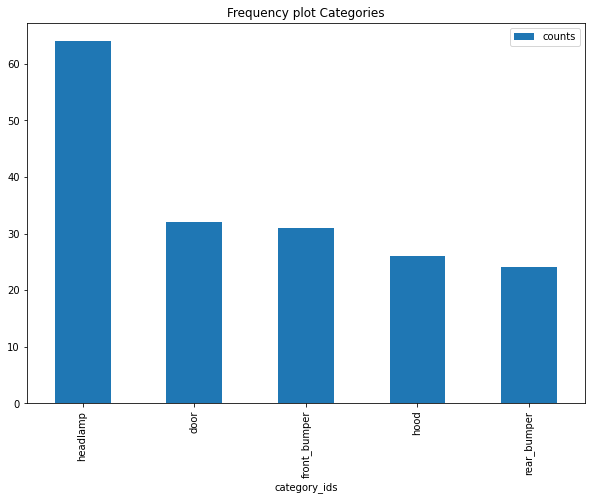

In [43]:
cat_df = pd.DataFrame({"category_ids":cat_ids}).\
                value_counts(normalize=False).\
                reset_index().\
                rename(columns={0:"counts"})
cat_df.plot(kind="bar", x="category_ids", figsize=[10,7])
plt.title("Frequency plot Categories")
_=plt.show()

## Sample Images from the dataset

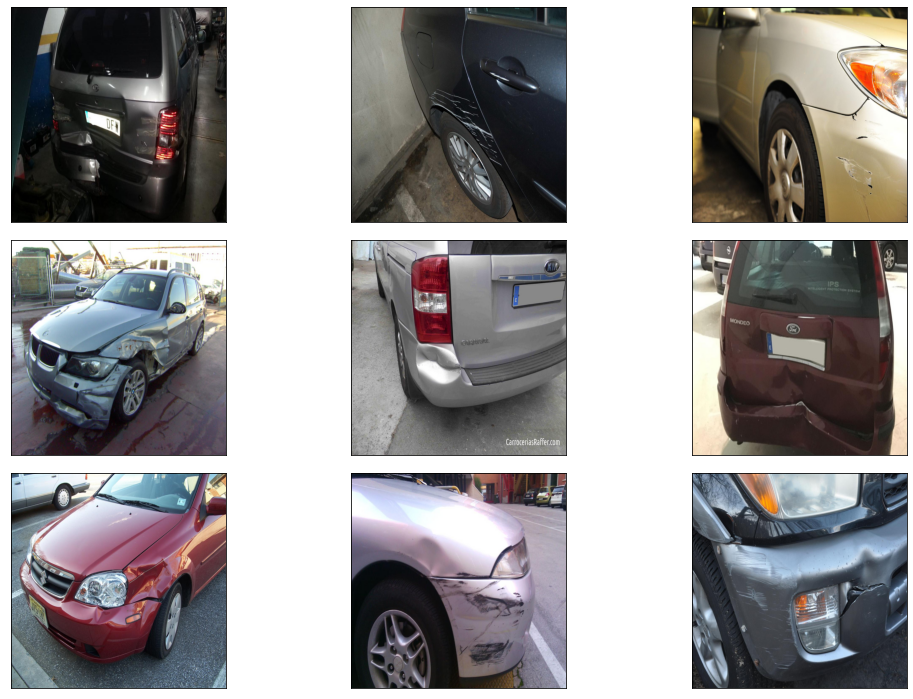

In [6]:
plt.figure(figsize=[15,10])
for idx, image in enumerate(train_images):
    img = plt.imread(image)
    plt.subplot(3,3,idx+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.show()

## Annotations Corelation
- x, y co-ordinates are distributed majorly between 0.4 to 0.6 of width and height
- width of the annotations in images are covers most of the area in compare to image
- height of the bounding box evenly distributed throughout the dataset

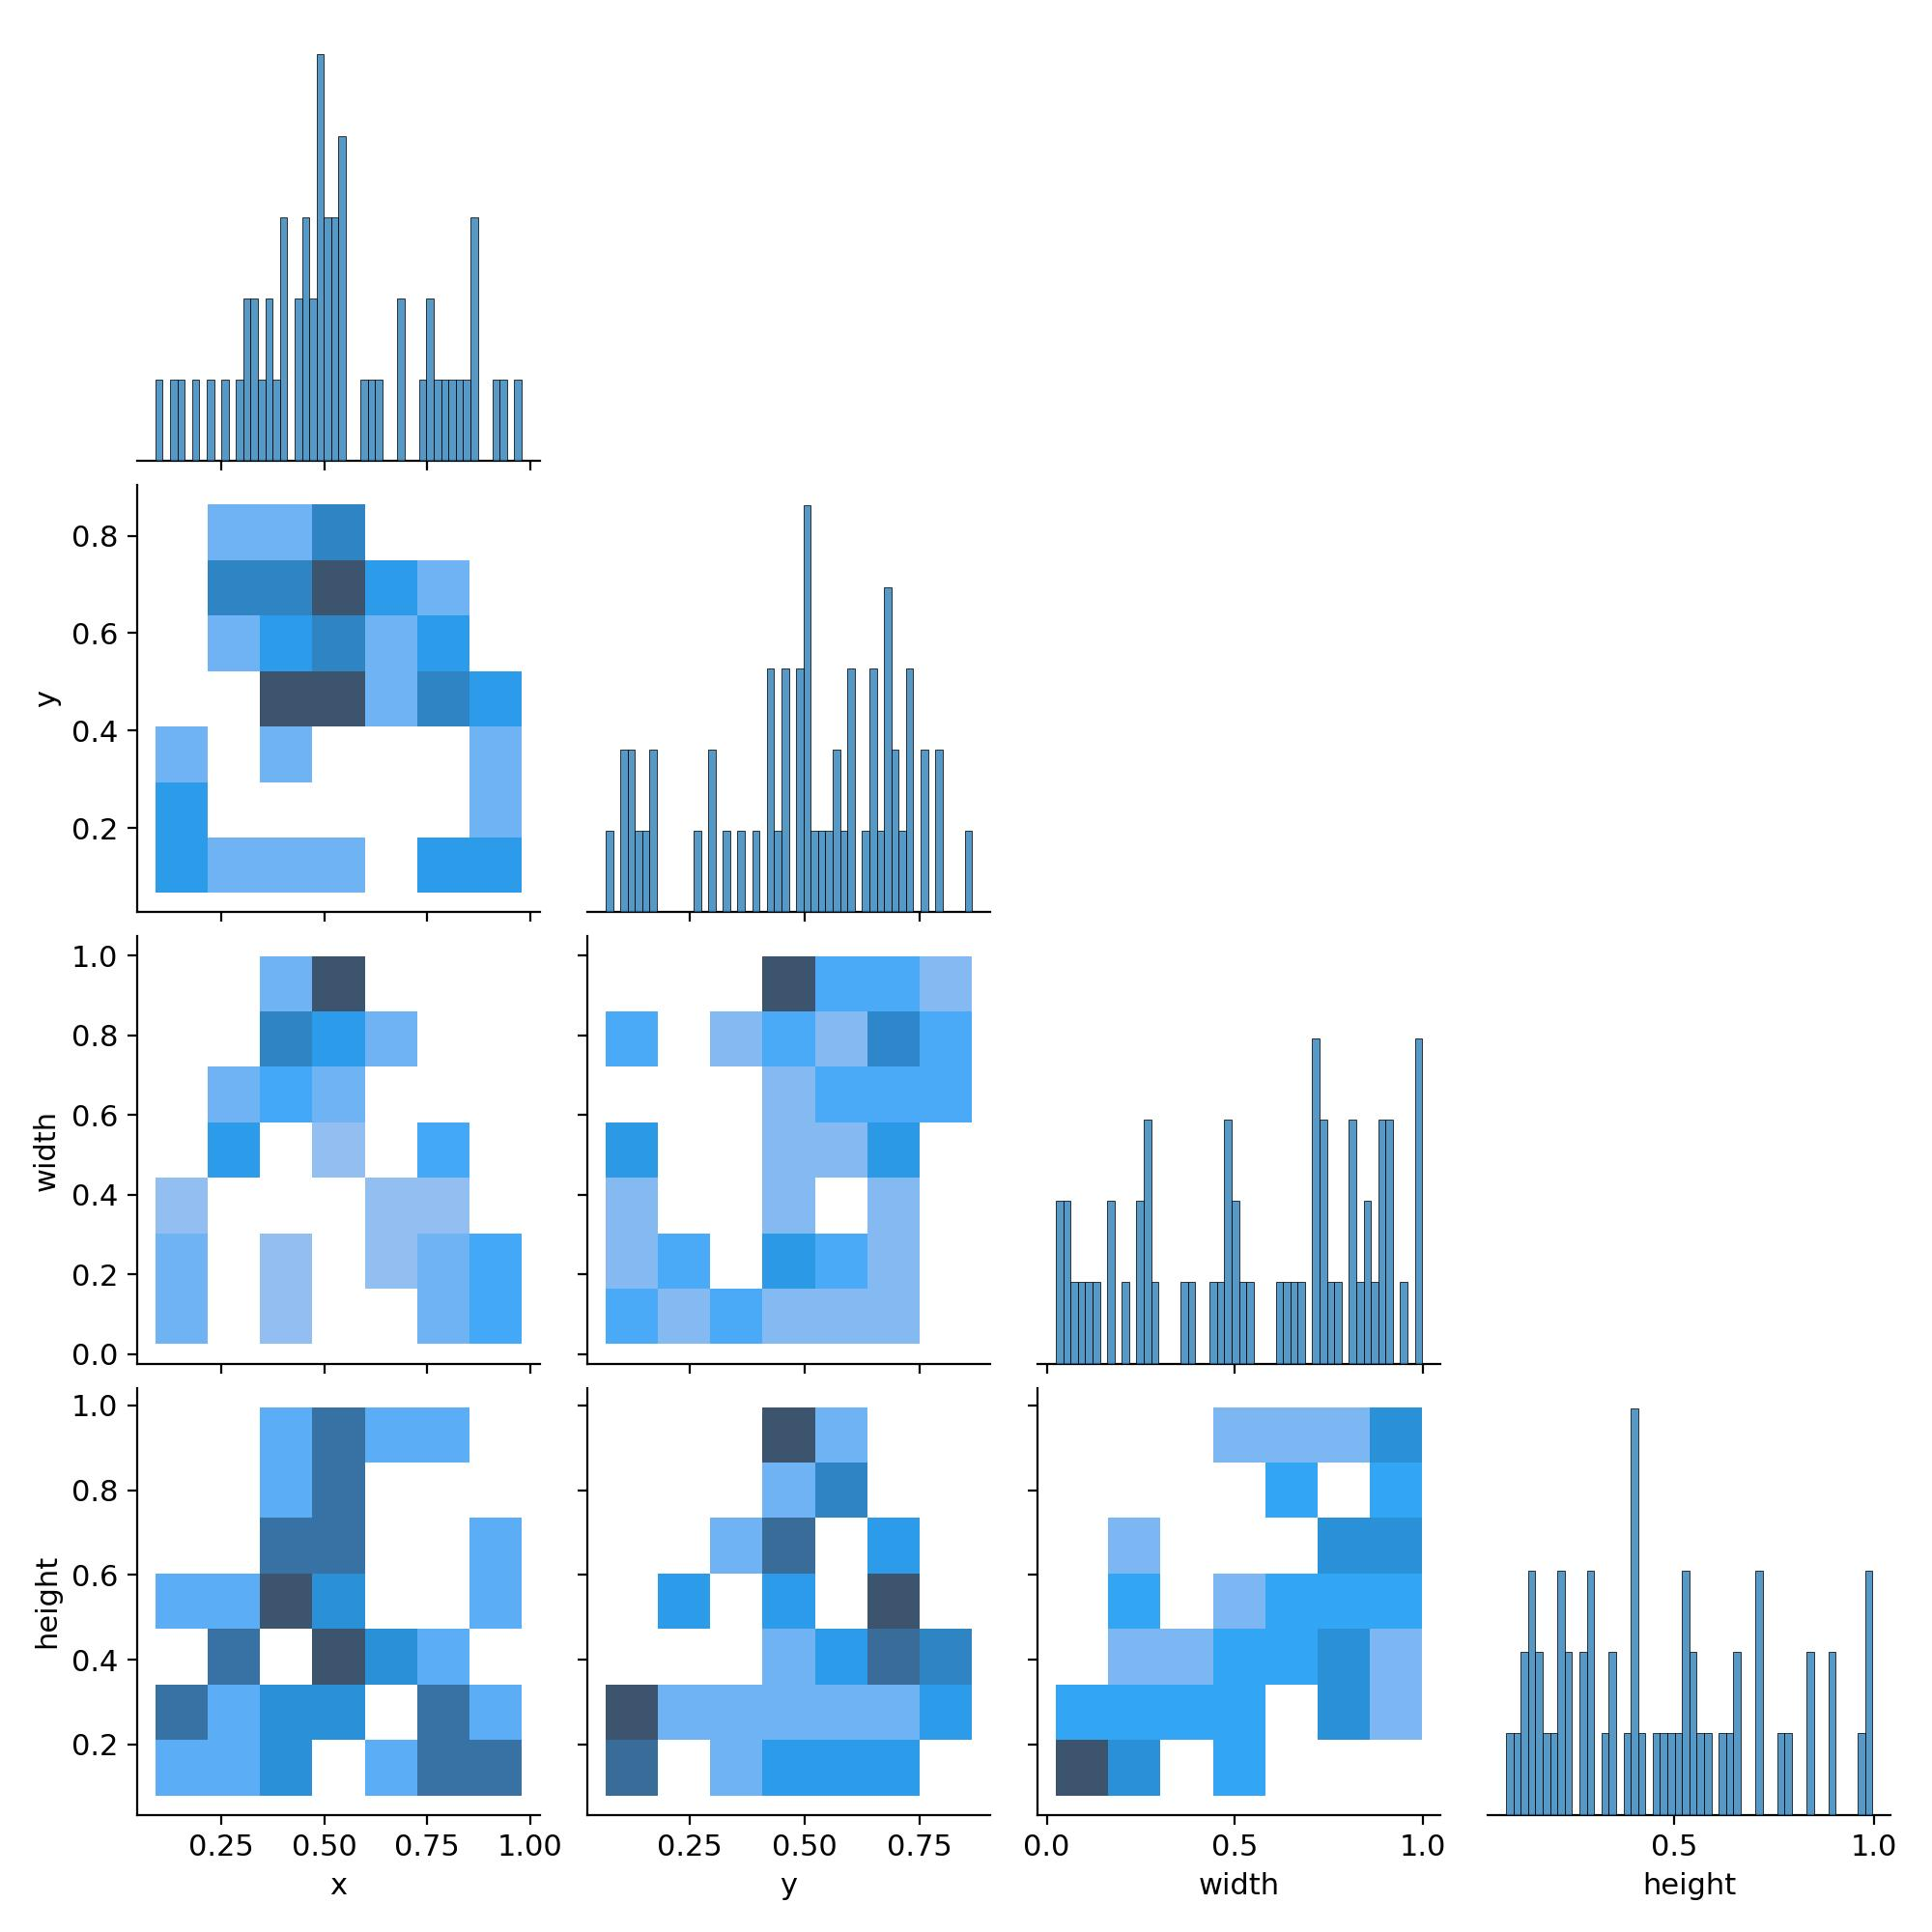

In [163]:
Image(filename="./runs/segment/train7/labels_correlogram.jpg")

## Sample segmented images 
- Damage is highlighted in the images
- It helps to segment the damages portion of the images 
- The mask size of door and hood is having higher pixel diversity which might add bias in the training
- Hood is having smallest mask and less diversity

In [91]:
mask_dict = {}
for annot in coco.getAnnIds():
    ann = coco.loadAnns(annot)[0]
    if ann["image_id"] in mask_dict.keys():
        mask_dict[ann["image_id"]].append(coco.annToMask(ann))
    else:
        mask_dict[ann["image_id"]] = [coco.annToMask(ann)]

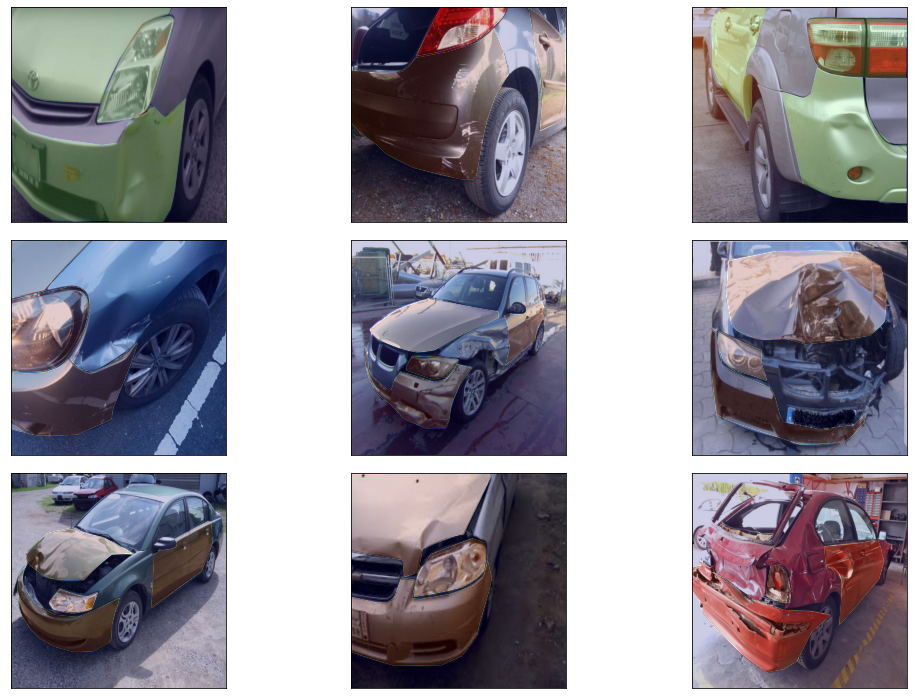

In [142]:
idx = 0
plt.figure(figsize=[15,10])
for key, val in mask_dict.items():
    if len(val) > 2:
        if idx>8:
            break
        plt.subplot(3,3,idx+1)
        plt.tight_layout()
        plt.xticks([])
        plt.yticks([])
        plt.imshow(plt.imread("./dataset/train/images/"+str(coco.imgs[key]["file_name"])))
        plt.imshow(np.sum(val, axis=0), cmap="jet",  alpha=0.2)
        idx+=1
plt.show()

# Existing approaches:
- Faster R-CNN: Slow network with RPN mechanism
- SSD: Faster Response time but lesser accuracy, longer training time
- Yolo Older Versions: Slower than SSD with remarkable accuracy and better community support

# Solution (YoloV8)
To detect the damage in the car damage detection dataset I will be using YoloV8 for image segmentation and object detection which helps to classify the damaged area in image that can be used to maintain the images captured by the tech support. 
- YoloV8 follows anchor less mechanism which makes this model faster in response time
- YOLOv8 has a high rate of accuracy measured by COCO and Roboflow 100
- YOLOv8 comes with a lot of developer-convenience features, from an easy-to-use CLI to a well-structured Python package
- There is a large community around YOLO and a growing community around the YOLOv8 model, meaning there are many people in computer vision circles who may be able to assist you when you need guidance

Reference: https://blog.roboflow.com/whats-new-in-yolov8/

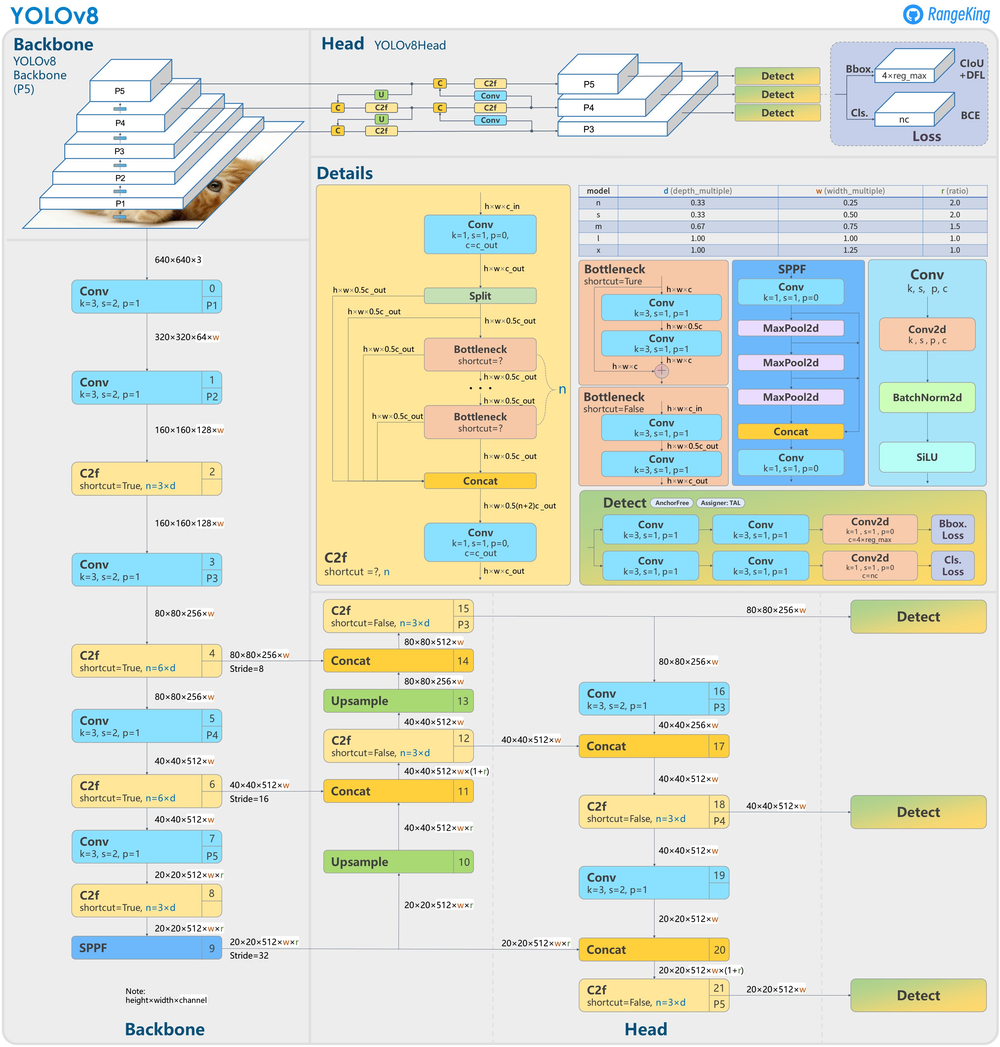

In [169]:
Image(filename="./yolov8-arch.png")

## Dataset Creation 
To train images with YoloV8 using ultralytics. Need to convert the annotations in yolo readable format and create the `.yaml` file for retraining the model

- Read the annotations and extract the segmentation data
- Normalize the segmentation data under range of (0 - 1)
- Target Segmentation values are polygon values
- Combine the classes and the segmentation values in `.txt` files
- Store all the images in the `images` folder
- Store all the segmentation files in the `labels` folder

Write `.yaml` file
<pre>
    nc: 5
    names: ['headlamp', 'rear_bumper', 'door', 'hood', 'front_bumper']
    train: /Users/dhruv/Documents/Research_tf_2_0/NewGen/yolo2/dataset/segment/train/images
    val: /Users/dhruv/Documents/Research_tf_2_0/NewGen/yolo2/dataset/segment/val/images
</pre>

In [143]:
idx = 0
annots = []
label_dict = {}
for obj in coco.getAnnIds():
    img_id = coco.loadAnns(obj)[0]["image_id"]
    if coco.loadImgs([img_id])[0]["file_name"] in list(label_dict.keys()):
        label_dict[coco.loadImgs([img_id])[0]["file_name"]] += "\n"+str(coco.loadAnns(obj)[0]["category_id"]-1)+" "+\
                                  " ".join((np.array(coco.loadAnns(obj)[0]["bbox"])/1024)
                                           .astype(str))
    else:
        label_dict[coco.loadImgs([img_id])[0]["file_name"]] = str(coco.loadAnns(obj)[0]["category_id"]-1)+" "+\
                                  " ".join((np.array(coco.loadAnns(obj)[0]["bbox"])/1024)
                                           .astype(str))

Store all the files in the dataset folder followed by labels

In [ ]:
for key, val in label_dict.items():
    with open("./dataset/train/labels/"+key.split(".")[0]+".txt", "w") as fp:
        fp.write(val)

# Training
- YoloV8 is very flexible in terms of training. It can be trained either of the way `[cli]` or `[python]`
- Params used while training process:
<pre>
task: segment
mode: train
data: yolov8_custom.yaml
model: yolov8n-seg.pt
epochs: 200
imgz: 640
device: mps
patience: 0
dropout: 0.2
nms: true
</pre>

 

In [146]:
model = YOLO("./yolov8n-seg.pt")
model.train(data="yolov8.yaml", epochs=200, imgsz=640, 
            batch=8, device="mps", patience=0, dropout=0.2, 
           nms=True)

Ultralytics YOLOv8.0.124 🚀 Python-3.9.9 torch-1.13.1 CPU
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
yolo/engine/trainer: task=segment, mode=train, model=./yolov8n-seg.pt, data=yolov8.yaml, epochs=200, patience=0, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      7/200         0G     0.9833      2.227      3.088      1.299          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11    0.00559      0.867     0.0782     0.0515    0.00466      0.767     0.0751     0.0293

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
      8/200         0G      1.048      1.921      2.988      1.381          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.453        0.2      0.274      0.144      0.453  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     23/200         0G      1.297      2.446      3.126      1.532          4        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.894        0.1      0.105     0.0538      0.894        0.1      0.106     0.0634

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     24/200         0G      1.333      2.251      2.788      1.552          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.888        0.1      0.106     0.0589      0.888  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     39/200         0G      1.096      2.049      2.451      1.366          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.128      0.419      0.209      0.144      0.128      0.419      0.209      0.107

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     40/200         0G      1.105      2.284      2.602      1.396          4        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.693        0.2      0.189      0.102      0.693  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     55/200         0G      1.047      1.607      2.104      1.312          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.115      0.467      0.242      0.135     0.0939      0.367      0.215      0.125

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     56/200         0G      1.055      1.755      2.221      1.326          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.112      0.467      0.246      0.131     0.0902  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     71/200         0G      1.036      1.618        2.2      1.316          7        640: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.312      0.367      0.184      0.136      0.312      0.367      0.184      0.116

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     72/200         0G     0.9452      1.555      2.023      1.249          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.709        0.3      0.195      0.136      0.992  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     87/200         0G     0.9495      1.608      1.842      1.218         11        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.994        0.1      0.157      0.107      0.994        0.1      0.153      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
     88/200         0G     0.9396       1.19      1.666      1.231          9        640: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.994        0.1      0.152      0.104      0.994  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    103/200         0G     0.7606      1.092       1.56      1.133          9        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.437      0.261      0.307      0.206      0.437      0.261      0.289      0.209

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    104/200         0G     0.8438      1.084      1.496      1.146          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11        0.6      0.196      0.284      0.194        0.6  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    119/200         0G     0.7502      1.422      1.498      1.124          4        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.693      0.262      0.273      0.189      0.693      0.262      0.272      0.175

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    120/200         0G     0.7454      1.173      1.313      1.112          8        640: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.656       0.25      0.266      0.197      0.656  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    135/200         0G     0.7784     0.9693       1.32      1.194          6        640: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.568      0.159       0.21      0.165      0.568      0.159       0.21      0.162

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    136/200         0G     0.7161      1.017      1.387      1.065          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.336      0.292      0.207      0.154      0.336  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    151/200         0G      0.608     0.8931      1.127      1.035          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.406      0.399      0.282      0.203      0.406      0.399      0.281      0.202

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    152/200         0G     0.5812     0.7938      1.129      1.017          8        640: 100%|██████████| 8/8 [00:11<00:00,  1.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.375      0.433      0.279      0.192      0.375  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    167/200         0G     0.6169     0.8969      1.116       1.07          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.547        0.3       0.21      0.165      0.547        0.3       0.21      0.173

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    168/200         0G     0.6083     0.8756      1.094      1.007          6        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.538        0.3        0.2      0.159      0.538  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    183/200         0G     0.5238     0.6651     0.9282      1.027          9        640: 100%|██████████| 8/8 [00:11<00:00,  1.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11       0.64       0.35      0.266      0.184       0.64       0.35      0.265      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    184/200         0G     0.5553     0.7167      1.033     0.9854          4        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.625      0.357      0.242      0.171      0.625  


      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    199/200         0G     0.4866     0.7042      1.008     0.9563          4        640: 100%|██████████| 8/8 [00:11<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.431       0.42      0.256      0.189      0.431       0.42      0.254      0.184

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size
    200/200         0G     0.4793     0.6821      0.896     0.9709          5        640: 100%|██████████| 8/8 [00:11<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [
                   all         11         11      0.428      0.421      0.256      0.196      0.428  

## Training Inference Analysis
- Losses are converging well but frequent ups and downs can be seen
- By increasing the dataset size, training might be able to give better results
- Validation metrics shows that the model is more focused on the precision than the recall
    - High precision indicates the proportion of predicted damaged areas that are actually correct which helps in the senarios where false alarms can be costly
    - High recall indicates the system's ability to detect damaged areas accurately which means that the system ensures that only fewer damaged areas go undetected
    - F1-Score is the best metric to understand the over all performance but precision and recalls can be seperately used based on specific requirements

In [149]:
test_images = glob("./dataset/test/*.jpg")

In [150]:
model = YOLO("./runs/segment/train7/weights/last.pt")
out = model.predict(test_images[:10], save=True, conf=0.35)


0: 640x640 3 rear_bumpers, 1 hood, 1: 640x640 3 doors, 2: 640x640 2 rear_bumpers, 1 front_bumper, 3: 640x640 1 door, 4: 640x640 (no detections), 5: 640x640 1 rear_bumper, 6: 640x640 1 front_bumper, 7: 640x640 1 rear_bumper, 484.0ms
Speed: 1.8ms preprocess, 60.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict16


## Tested images
- Using `last.pt` model is able to give fair results
- Based on the metrics, model has not performed well but loss is converging
- By increasing the dataset size and quality of annotations. Model can show better results

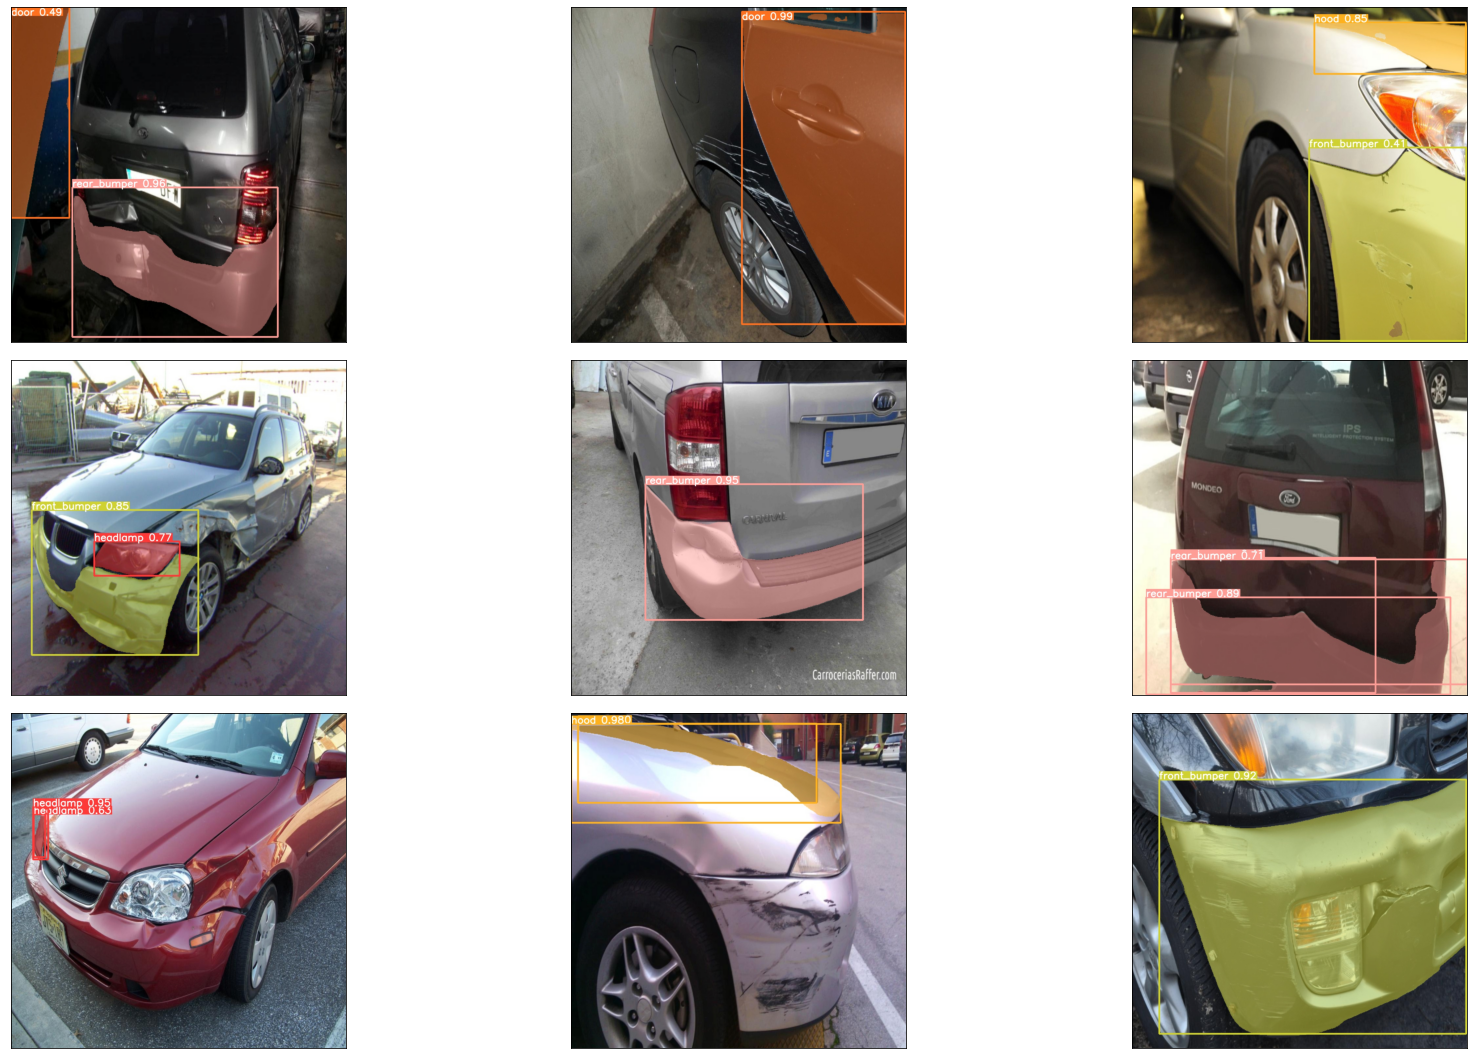

In [153]:
results = glob("runs/segment/predict16/*.jpg")
plt.figure(figsize=[25,15])
for idx, image in enumerate(results[:9]):
    img = plt.imread(image)
    plt.subplot(3,3,idx+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.show()

# Evaluation Metrics
## F1-Confidence Curve
- Near the confidence threshold value `0.35`, the F1-Score is balanced for all the classes
- All classes averagely shown `0.36` F1-Score at `0.595` Confidence threshold
- `front_bumper` and `headlamp` classes hidden from the curve
- Based on the F1-Confidence Curve, hood is dominating the predictions. 

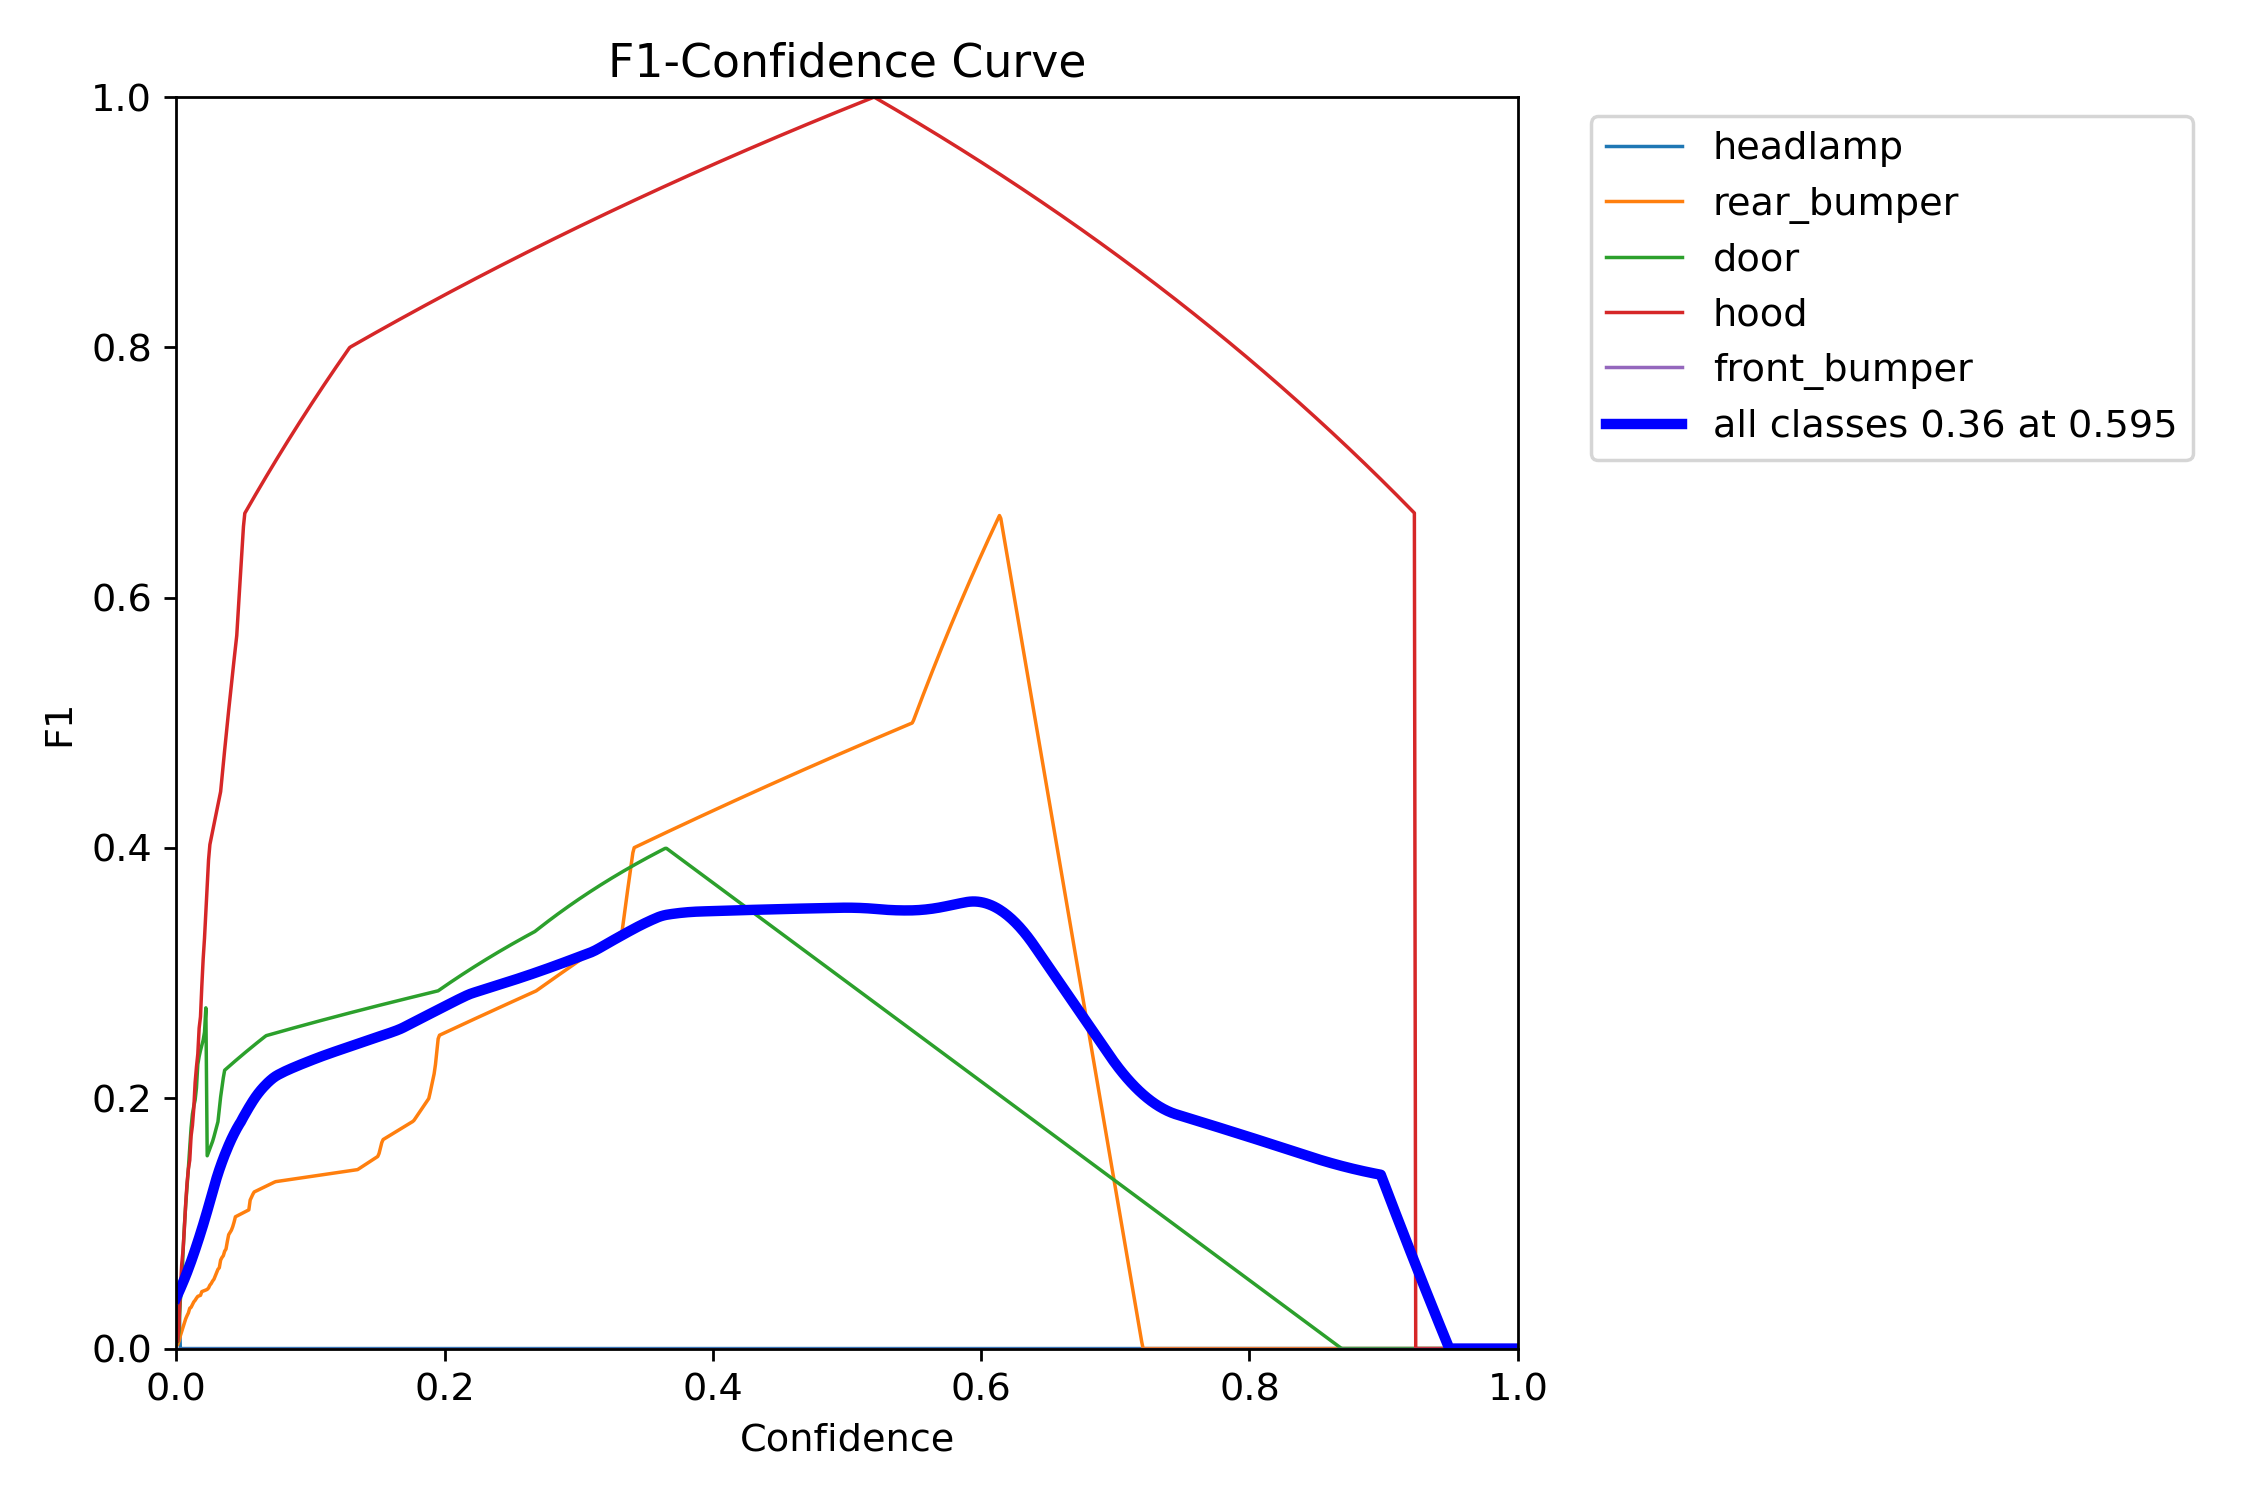

In [158]:
Image(filename="./runs/segment/train7/BoxF1_curve.png")

## Training Results
- Training loss converging smoothly but val loss does not show the smooth converging. As the val images are only 11, this might be the case for non smooth curve but model tried to reduce the loss
- Precision and recall for both B (Bounding Box) and M (Mask) not showing good results. 
- Initially precision and recall are not stable but the epochs increasing the results are more stable and less fluctuations can be seen

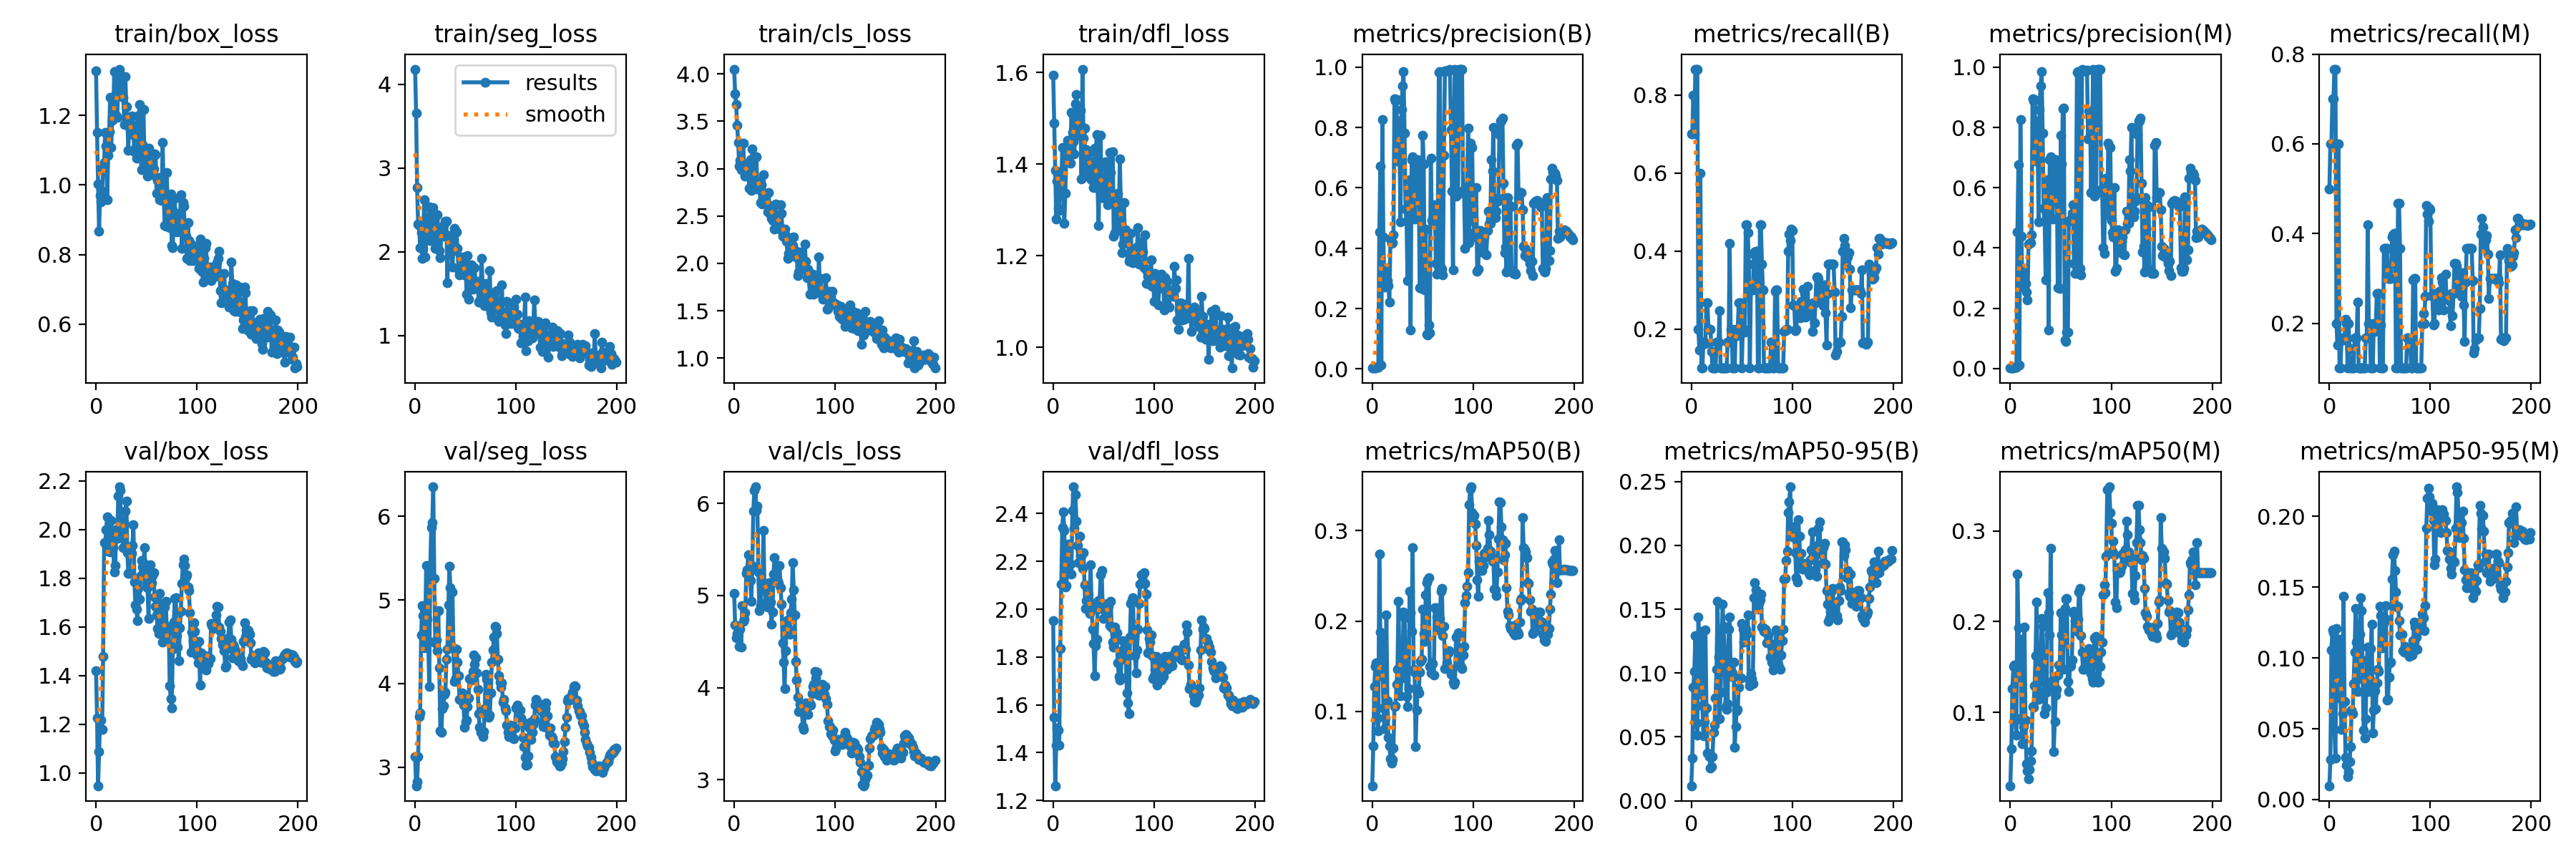

In [164]:
Image(filename="./runs/segment/train7/results.png")

# Validation Image Set
## True annotations for the images


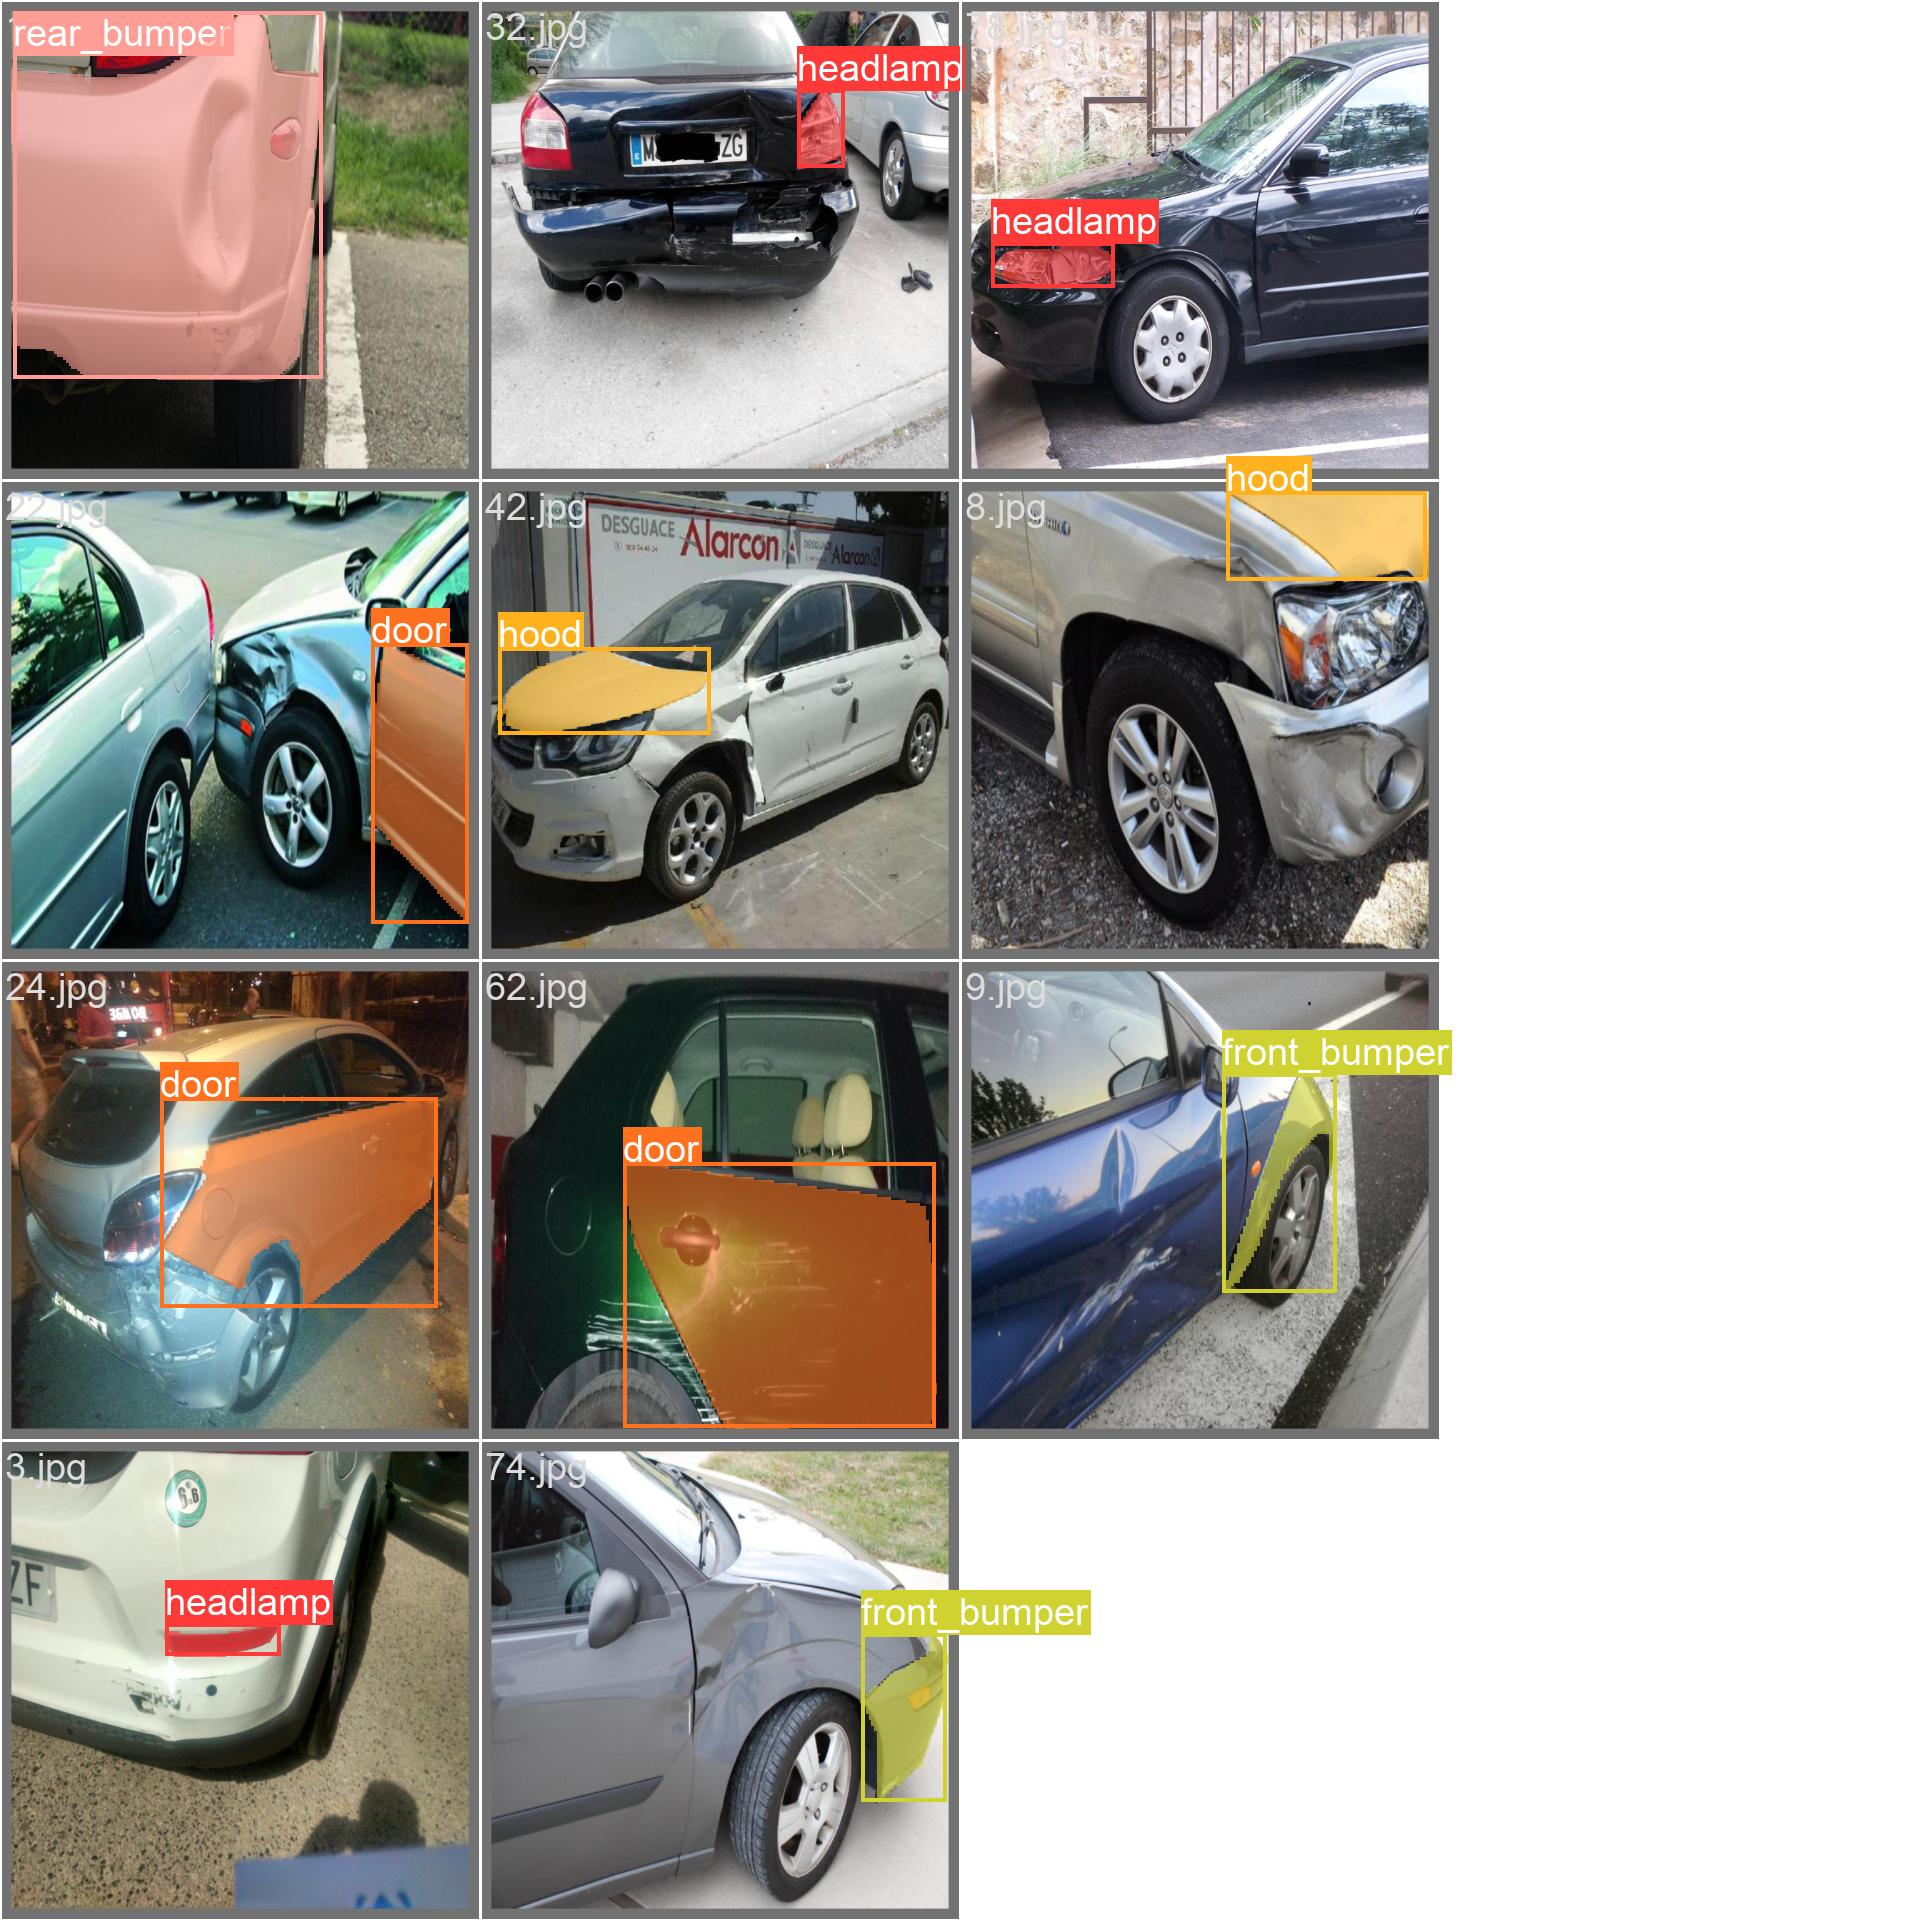

In [166]:
Image(filename="./runs/segment/train7/val_batch0_labels.jpg")

## Predicted annotations for the validation images

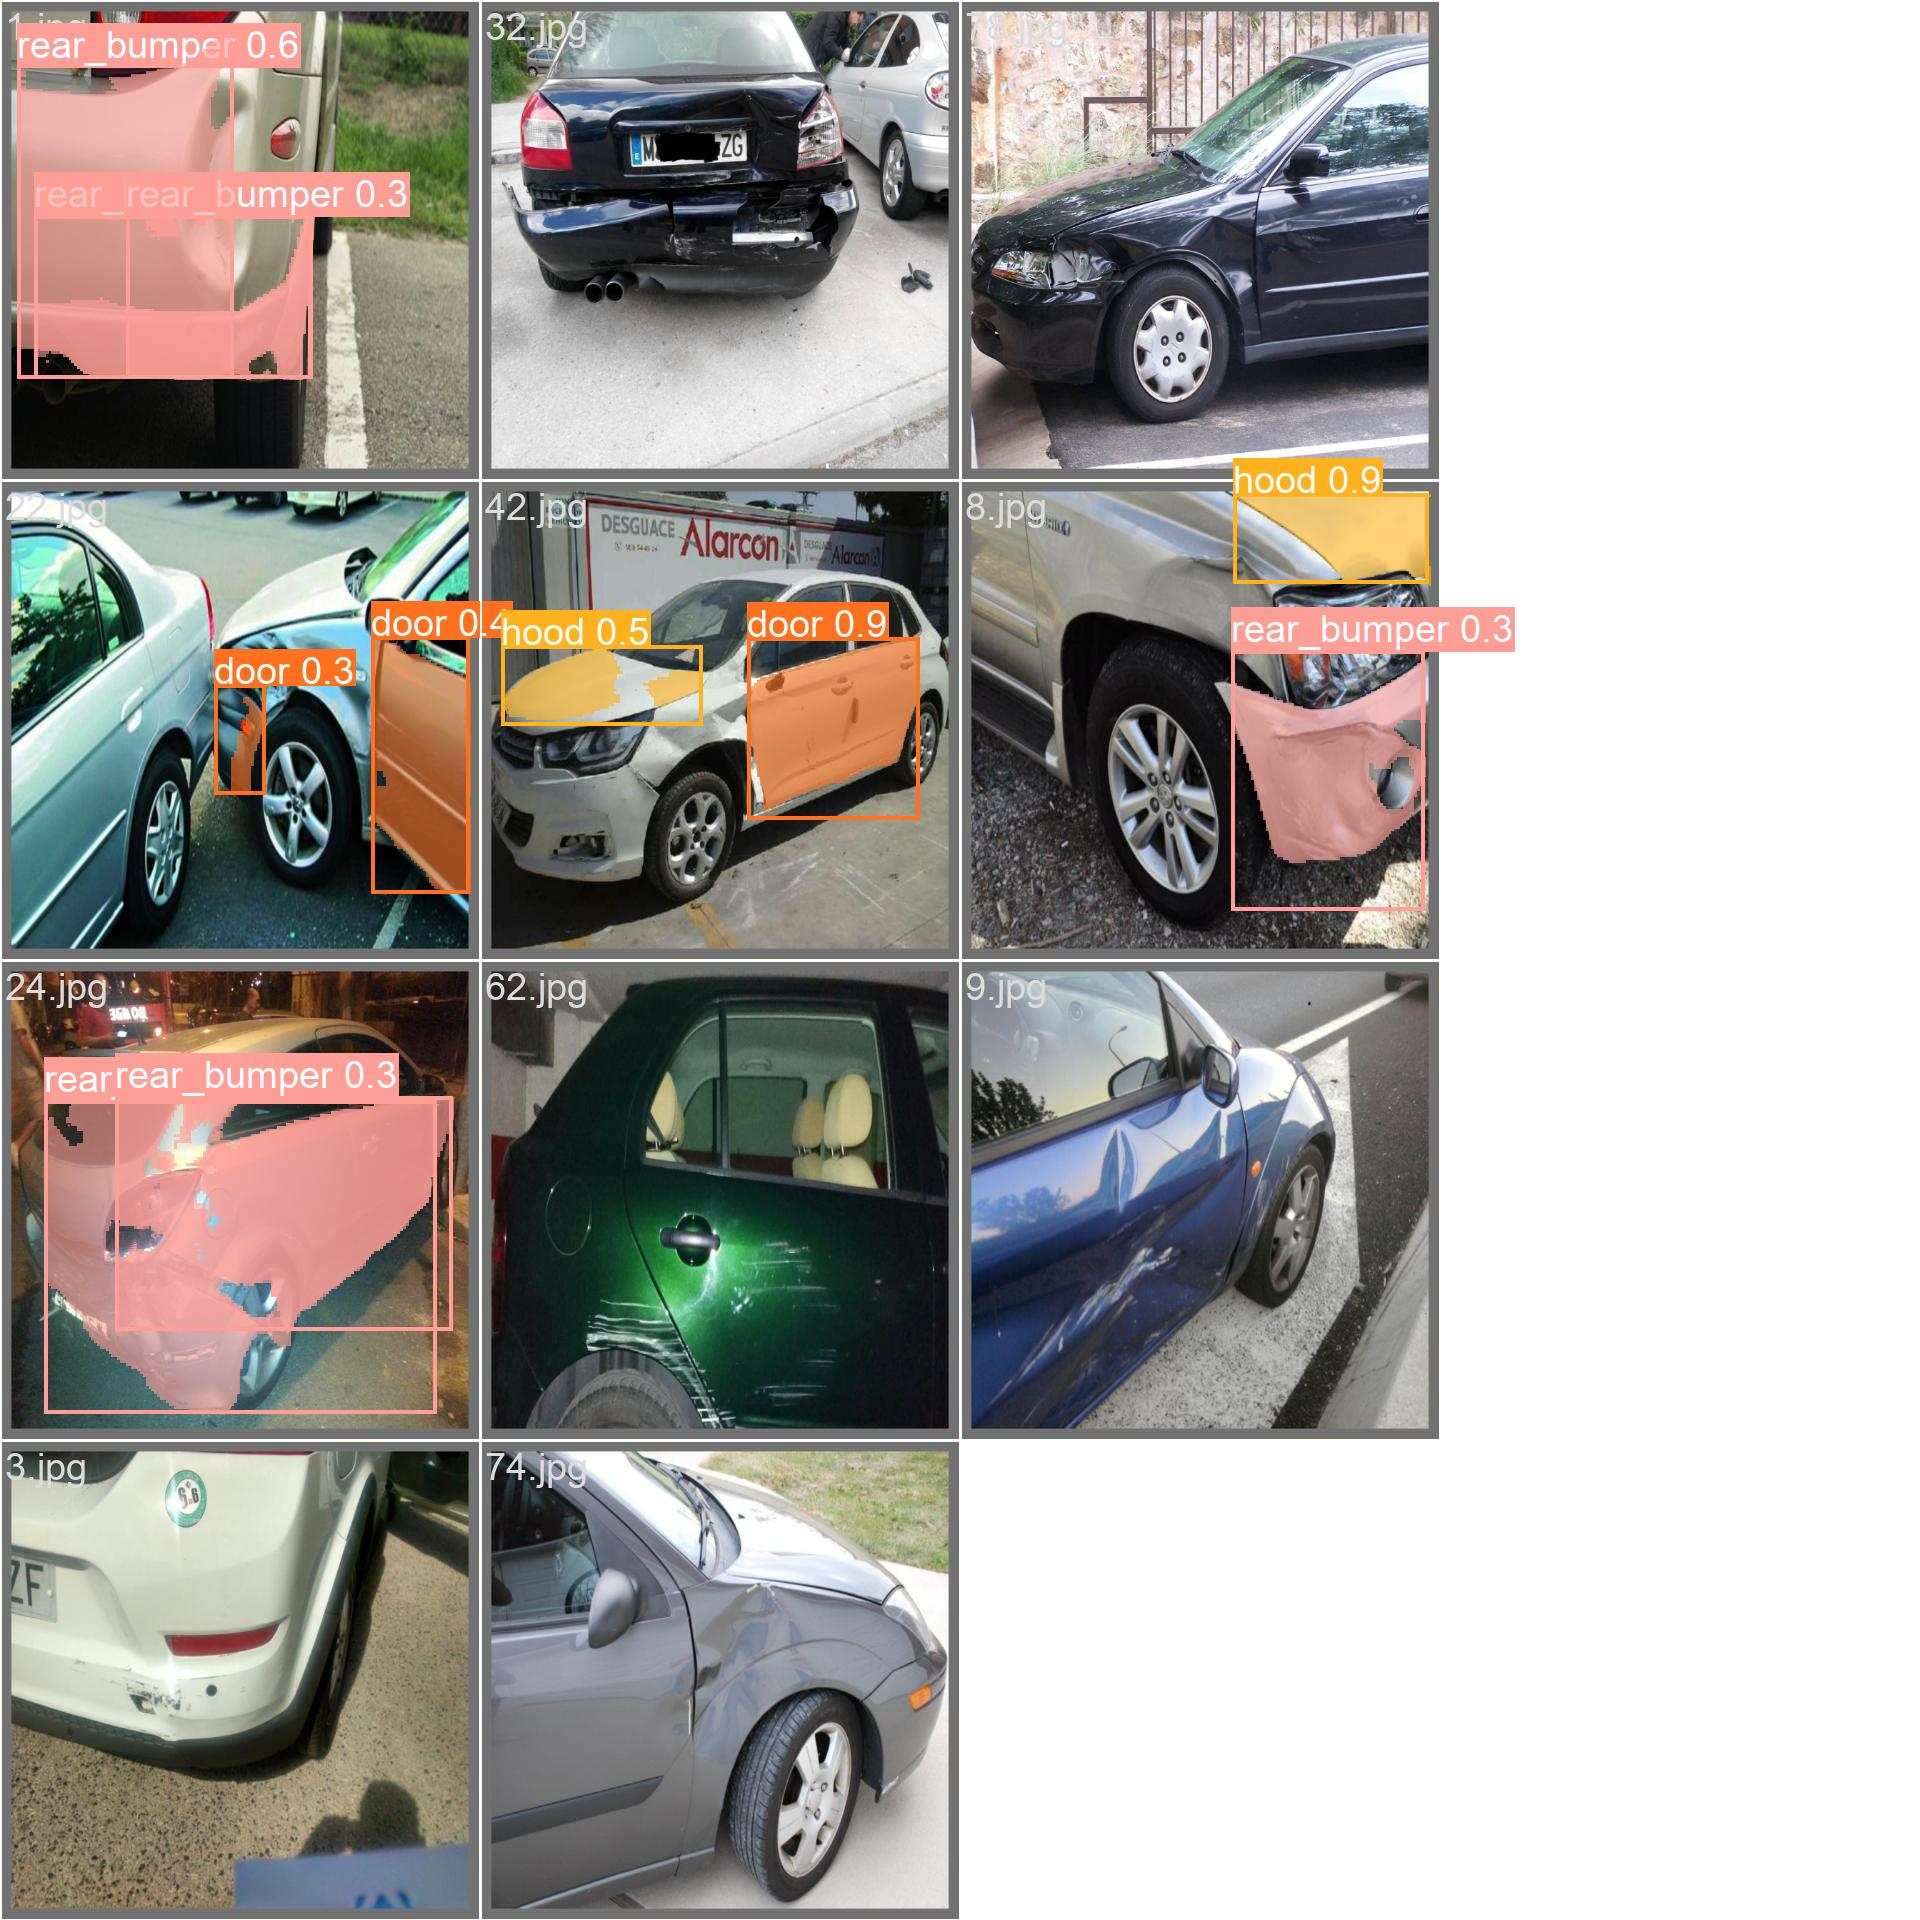

In [167]:
Image(filename="./runs/segment/train7/val_batch0_pred.jpg")

# Conclusion
`last.pt` performs well than `best.pt` weights. 

In conclusion, YOLOv8 has proven to be a highly effective tool for car damage detection. Its utilization in understanding and identifying damaged areas of cars holds great potential in various applications, including insurance claims processing and data maintenance in the automotive industry.

During the training process, YOLOv8 demonstrated a good convergence rate when compared to the dataset size used. This indicates that the model is able to effectively learn from the available data and generalize well to new instances of car damage.

To further enhance the performance and capabilities of YOLOv8 in car damage detection, there are opportunities for improvement by increasing the dataset size. By incorporating a larger and more diverse collection of car damage images into the training data, the model can learn to recognize and localize various types of damage with greater accuracy and reliability.

It's worth noting that beyond increasing the dataset size, there are other relevant techniques that can be explored to enhance the performance of YOLOv8. These might include data augmentation techniques, architecture modifications, transfer learning, or fine-tuning on specific car damage datasets.

Overall, YOLOv8 offers a powerful solution for car damage detection, and with the application of these advancements, its potential in insurance claims processing and data maintenance tasks can be further realized, providing valuable insights and streamlining the overall process.

# Future Work 
No doubt, YoloV8 is the state-of-the-art algorithm for object detection. But, as in the case of insurance claims there are multiple choices available for the process automation.
- Object detection and segmentation can limits the ability of system to detecting and maintaining the data
- With the combination of different object detection models and NLP, we can achieve better results like:
    - Generation of image summary: This can be done by combining the object detection and image captioning
    - Objects can be further classified at multiple level
    - Based on customer provided details classify the detected damage as True or False

# Recommendations
- Segmenting Deep Features of Damage: Consider incorporating the UNet architecture for segmenting small features in car damage images. UNet has shown remarkable results in semantic segmentation tasks and can potentially help in accurately segmenting the damaged areas of cars, providing more detailed information for insurance claims processing and data maintenance.

- Detection Transformer for Customization: Explore the use of Detection Transformers, such as the DETR model, which offer a powerful alternative to YOLOv8. Detection Transformers provide better flexibility and customization options, allowing you to tailor the model architecture and parameters to suit the specific requirements of car damage detection tasks.

- Integration with NLP Tasks: Leverage the added advantage of Detection Transformers, which can integrate well with natural language processing (NLP) tasks. This integration can be beneficial in scenarios where textual information about car damage, such as descriptions or insurance claim reports, can be combined with the visual detection results to gain deeper insights.

- Training on Customly Defined Dataset: Instead of relying solely on pretrained networks trained on datasets like COCO or VOC, consider creating a custom dataset specifically for car damage detection. Training on a custom dataset helps to address the challenge of transfer learning biases and allows you to set the benchmark for similar tasks, ensuring the model is trained on relevant and representative data.

- Reduce Bias and Set Benchmark: Custom training enables you to reduce any biases introduced by transferred weights from pretrained models. By training on a custom dataset, you have greater control over the data collection process, ensuring it aligns with the specific characteristics and challenges of car damage detection. This approach helps to establish a benchmark performance and provides a more accurate evaluation of the model's capabilities.
